In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from astropy.io import ascii, fits
import matplotlib.pyplot as plt

from itertools import combinations_with_replacement

from dr25 import quad

In [3]:
durations = np.array([1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0])

In [4]:
stlr = ascii.read("data/q1_q17_dr25_stellar.txt").to_pandas()

In [5]:
cdpp_cols = ["rrmscdpp01p5", "rrmscdpp02p0", "rrmscdpp02p5", "rrmscdpp03p0",
             "rrmscdpp03p5", "rrmscdpp04p5", "rrmscdpp05p0", "rrmscdpp06p0",
             "rrmscdpp07p5", "rrmscdpp09p0", "rrmscdpp10p5", "rrmscdpp12p0",
             "rrmscdpp12p5", "rrmscdpp15p0"]

pars = stlr[cdpp_cols + ["kepid", "limbdark_coeff1", "limbdark_coeff2", "limbdark_coeff3", "limbdark_coeff4", "dataspan", "dutycycle"]]

In [6]:
robo = ascii.read("data/kplr_dr25_inj1_tces.txt").to_pandas()
df = ascii.read("data/kplr_dr25_inj1_plti.txt").to_pandas()
df["kepid"] = df.KIC_ID.astype(int)
print(len(df))

m = df.i_depth > 0.0
df = df[m]
print(len(df))

146294
146262


In [7]:
joined = pd.merge(df, stlr, on="kepid", suffixes=("", "_stlr"))
joined = pd.merge(joined, robo, how="left", suffixes=("", "_robo"), on="TCE_ID")

m = joined.i_period < 100
m &= joined.EB_injection < 1.0
m &= joined.Offset_from_source < 1.0

m = (4200 <= joined.teff) & (joined.teff <= 6100)
m &= joined.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= joined.dataspan > 365.25*2.
m &= joined.dutycycle > 0.6
m &= joined.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(joined.mass)

joined = joined[m]
print("selected {0} / {1} injections".format(len(joined), len(df)))

# Find the best quadratic approximation to the non-linear limb darkening at b
c = np.array(joined[["limbdark_coeff1", "limbdark_coeff2", "limbdark_coeff3", "limbdark_coeff4"]], dtype=float)
b = np.array(joined.i_b)
r = np.clip(b, 1e-5, 1-1e-5)
mu = np.sqrt(1.0 - r**2)
u = np.array([1.0 - mu, (1.0 - mu)**2])
w = np.array([1.0 - np.sqrt(mu), 1.0 - mu, 1.0 - mu**1.5, 1.0 - mu**2]).T
f = np.sum(c * w, axis=1) / np.sum(u**2, axis=0)
g1, g2 = f[None, :] * u

# Compute the depth using this quadratic model
ror = np.array(joined.i_ror)
joined["depth"] = (1 - quad.quad(g1, g2, ror, b)) * 1e6

selected 67279 / 146262 injections


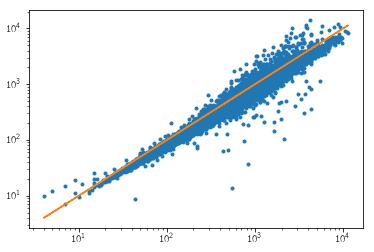

In [8]:
plt.loglog(joined.i_depth, joined.depth, ".")
plt.plot(joined.i_depth, joined.i_depth)

In [9]:
joined["onesig_approx"] = np.nan + np.zeros(len(joined))
for row, star in tqdm(joined.iterrows(), total=len(joined)):
    ntran = np.sqrt(star.i_period / star.dataspan * star.dutycycle)
    noise = np.interp(star.i_dur, durations, np.array(star[cdpp_cols], dtype=float))
    joined.loc[row, "onesig_approx"] = noise * ntran
joined["approx_mes"] = joined.depth / joined.onesig_approx

100%|██████████| 67279/67279 [01:40<00:00, 671.38it/s]


(0, 20)

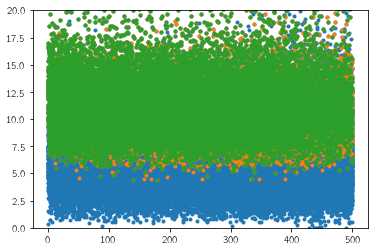

In [10]:
plt.plot(joined.i_period, joined.Expected_MES, ".")
m = joined.Recovered > 0
plt.plot(joined.i_period[m], joined.Expected_MES[m], ".")
m = joined.Disp == "PC"
plt.plot(joined.i_period[m], joined.Expected_MES[m], ".")
plt.ylim(0, 20)

(-26.85074310695113, 60.83838128346473)

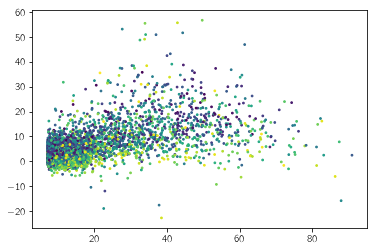

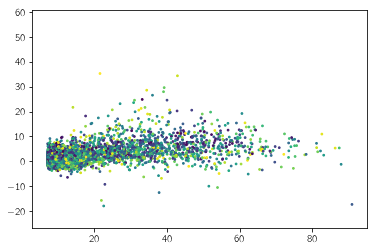

In [11]:
plt.scatter(joined.Measured_MES, joined.approx_mes - joined.Measured_MES, c=joined.i_period, s=3)
ylim = plt.ylim()
plt.figure()
plt.scatter(joined.Measured_MES, joined.Expected_MES - joined.Measured_MES, c=joined.i_period, s=3)
plt.ylim(ylim)

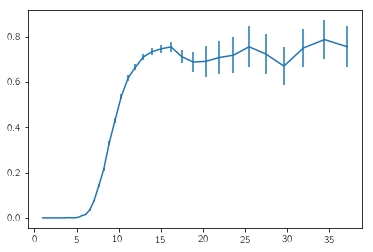

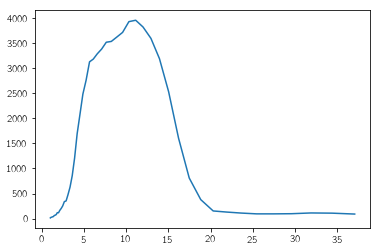

In [12]:
c = "approx_mes"
m0 = np.isfinite(joined[c])
m = m0 & (joined.Recovered > 0) & (joined.Disp == "PC")
bins = np.exp(np.linspace(0.0, np.log(40), 50))
n_tot, bins = np.histogram(np.array(joined[c][m0]), bins)
n_rec, _ = np.histogram(np.array(joined[c][m]), bins)
plt.errorbar(bins[:-1], n_rec / n_tot, yerr=np.sqrt(n_rec) / n_tot)

plt.figure()
plt.plot(bins[:-1], n_tot)

[0.73328935 9.56355694 0.08733908]


Text(0,0.5,'recovery rate')

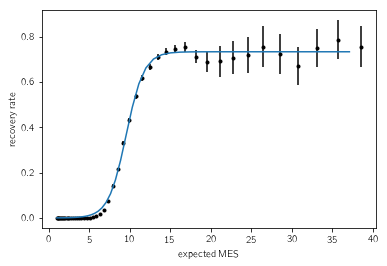

In [13]:
from scipy.optimize import leastsq

def model(p, mes):
    y = p[0] / (1.0 + np.exp(-(mes - p[1]) * np.exp(-p[2])))
    return y * (y <= 1.0) * (y > 0.0) + 1.0 * (y > 1.0)

m = joined.approx_mes < 18.0
y = np.array(joined.approx_mes[m])
z = np.array(((joined.Recovered > 0) & (joined.Disp == "PC"))[m], dtype=float)

resid = lambda p: (z - model(p, y))
p0 = np.array([0.7, 10.0, 0.08])
params, _, info, msg, flag = leastsq(resid, p0, full_output=True)
print(params)

plt.errorbar(0.5 * (bins[:-1] + bins[1:]), n_rec / n_tot, yerr=np.sqrt(n_rec) / n_tot, fmt=".k", zorder=-1)
plt.plot(bins[:-1], model(params, bins[:-1]))
plt.xlabel("expected MES")
plt.ylabel("recovery rate")

In [43]:
def _get_filename(kicid, suffix):
    kid_str = "{0:09d}".format(kicid)
    path = os.path.join("data", "pdm", kid_str[:3], kid_str[:6], kid_str, "tps")
    return os.path.join(path, "kplr{0}_dr25_{1}.fits".format(kid_str, suffix))

def _load_and_get_pdm(kicid, duration, period, suffix, column):
    ind = np.searchsorted(durations, duration)
    fn = _get_filename(kicid, suffix)
    with fits.open(fn) as f:
        if ind >= len(f)-1:
            x = f[-1].data["PERIOD"]
            y = f[-1].data[column]
            return np.interp(period, x, y)
        if ind == 0:
            x = f[1].data["PERIOD"]
            y = f[1].data[column]
            return np.interp(period, x, y)
        x = f[ind].data["PERIOD"]
        y = f[ind].data[column]
        minus = np.interp(period, x, y)
        x = f[ind+1].data["PERIOD"]
        y = f[ind+1].data[column]
        plus = np.interp(period, x, y)
        m = (duration - durations[ind-1]) / (durations[ind] - durations[ind-1])
        return minus + (plus - minus) * m

    
def get_pdm(kicid, duration, period, one_sigma_depth=True, window=False):
    osd = None
    if one_sigma_depth:
        osd = _load_and_get_pdm(kicid, duration, period, "onesigdepth", "ONESIGDEP")
        if not window:
            return osd
    win = None
    if window:
        win = _load_and_get_pdm(kicid, duration, period, "window", "WINFUNC")
        if not one_sigma_depth:
            return win
    return osd, win

In [46]:
joined["onesig_exact"] = np.nan + np.zeros(len(joined))
for row, star in tqdm(joined.iterrows(), total=len(joined)):
    try:
        joined.loc[row, "onesig_exact"] = get_pdm(star.kepid, star.i_dur, star.i_period)
    except (FileNotFoundError, TypeError):
        pass


100%|██████████| 11606/11606 [01:47<00:00, 108.28it/s]


(-110.16277457826506, 88.3105497385709)

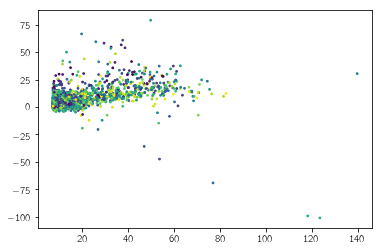

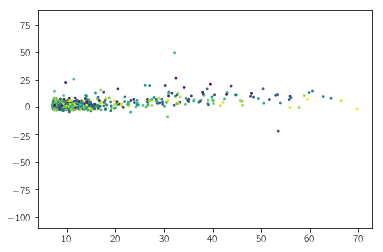

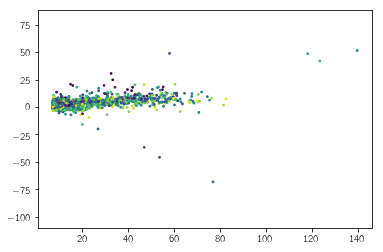

In [47]:
plt.scatter(joined.Measured_MES, joined.depth / joined.onesig_approx - joined.Measured_MES, c=joined.i_period, s=3)
ylim = plt.ylim()
plt.figure()
plt.scatter(joined.Measured_MES, joined.depth / joined.onesig_exact - joined.Measured_MES, c=joined.i_period, s=3)
plt.ylim(ylim)
plt.figure()
plt.scatter(joined.Measured_MES, joined.Expected_MES - joined.Measured_MES, c=joined.i_period, s=3)
plt.ylim(ylim)

In [518]:
get_pdm(3343187, 3.7, 10.2345)

26.065136620860727

In [720]:
datasets = []
kepid = 3343187
with fits.open(_get_filename(kepid, "onesigdepth")) as f:
    for i, hdu in enumerate(f[1:]):
        d = np.vstack((
            np.ones(len(hdu.data)) * durations[i],
            hdu.data["PERIOD"],
            hdu.data["ONESIGDEP"],
        )).T
        datasets.append(d)

[ -0.11939498   1.34081185  -6.20709793  15.26463181 -21.37271917
  16.88101492  -7.32561215   3.77091201]


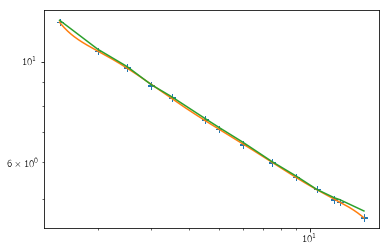

In [727]:
X = np.concatenate(datasets)
m = np.all(np.isfinite(X), axis=1)
m &= X[:, 1] < 100

duration, period, onesig = X[m].T
p = np.polyfit(np.log(duration), np.log(onesig) - 0.5*np.log(period), 7)
print(p)

plt.loglog(duration, onesig / np.sqrt(period), "+")
x = np.linspace(durations.min(), durations.max(), 1000)
plt.plot(x, np.exp(np.polyval(p, np.log(x))))

star = stlr[stlr.kepid == kepid].iloc[0]
plt.loglog(durations, star[cdpp_cols]/np.sqrt(star.dataspan * star.dutycycle))

In [724]:
ntran = np.sqrt(period / star.dataspan * star.dutycycle)
onesig = star[cdpp_cols]

32.86573816301712

In [673]:
def get_design_matrix(X):
    As = [np.concatenate((np.ones((len(X), 1)), X), axis=1)]
    for order in range(2, 7):
        As.append(np.product(list(
            combinations_with_replacement(X.T, order)), axis=1).T)
    return np.concatenate(As, axis=1)

X = np.concatenate(datasets)
m = np.all(np.isfinite(X), axis=1)
m &= X[:, 1] < 100
X = np.log(X[m])
y = np.array(X[:, 2])
X = X[:, :2]
A = get_design_matrix(X)

m = np.ones(len(A), dtype=bool)
for i in range(10):
    w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
    pred = np.dot(A, w)
    resid = y - pred
    sigma = np.std(resid)
    m_new = np.abs(resid) < 3 * sigma
    if m.sum() == m_new.sum():
        m = m_new
        break
    m = m_new

w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
print(w.shape)

(28,)


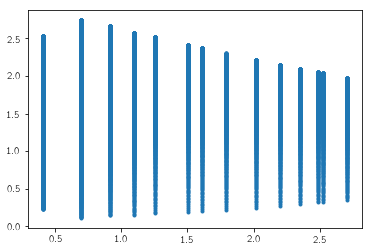

In [674]:
plt.plot(X[:, 0], y, ".")

(28000, 2)


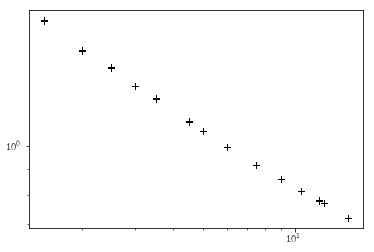

In [682]:
x = np.log(durations)
y = np.linspace(X[:, 1].min(), X[:, 1].max(), 2000)
X_pred = np.vstack([a.flatten() for a in np.meshgrid(x, y, indexing="ij")]).T
print(X_pred.shape)
A_pred = get_design_matrix(X_pred)

for d in datasets[::-1]:
    z, x, y = d.T
    m = np.isfinite(y)
    m &= x < 100
    a = z[m]
    b = y[m] / np.sqrt(x[m])
    plt.loglog(a, b, "+k")

# ylim = plt.ylim()
# plt.plot(np.exp(X_pred[:, 1]), np.exp(np.dot(A_pred, w)), ".", ms=1, alpha=0.5)
# plt.ylim(ylim)

In [542]:
datasets

[array([[ 1.5       ,  0.5       ,  1.98308694],
        [ 1.5       ,  0.50240338,  1.98789358],
        [ 1.5       ,  0.50480974,  1.99259281],
        ...,
        [ 1.5       , 50.04010391, 19.85443306],
        [ 1.5       , 50.04260635, 19.85457039],
        [ 1.5       , 50.04510498, 19.8543644 ]]),
 array([[  2.        ,   0.52083337,   1.80086207],
        [  2.        ,   0.52729529,   1.81194723],
        [  2.        ,   0.53375214,   1.82303333],
        ...,
        [  2.        , 118.61283112,  27.23800659],
        [  2.        , 118.61923981,  27.2385273 ],
        [  2.        , 118.6256485 ,  27.23845863]]),
 array([[  2.5       ,   0.65104169,   1.8972857 ],
        [  2.5       ,   0.66554612,   1.91831946],
        [  2.5       ,   0.68006301,   1.93910861],
        ...,
        [  2.5       , 231.66067505,  35.93149185],
        [  2.5       , 231.67555237,  35.94076157],
        [  2.5       , 231.69042969,  35.9343338 ]]),
 array([[  3.        ,   0.78125   , 

In [385]:
from tqdm import tqdm
joined["mes_model"] = np.nan + np.zeros(len(joined))
for i, star in tqdm(joined.iterrows(), total=len(joined)):
    try:
        osd = get_pdm(star.kepid, star.i_dur, star.i_period)
    except FileNotFoundError:
        continue
    joined.loc[i, "mes_model"] = star.depth / osd

100%|██████████| 2000/2000 [00:08<00:00, 230.46it/s]


In [304]:
joined.mes_model

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23     10.966249
24     10.273018
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
         ...    
970          NaN
971          NaN
972          NaN
973          NaN
974          NaN
975          NaN
976          NaN
977          NaN
978          NaN
979          NaN
980          NaN
981          NaN
982          NaN
983          NaN
984          NaN
985          NaN
986          NaN
987          NaN
988          NaN
989          NaN
990          NaN
991          NaN
992          NaN
993          NaN
994          NaN
995          NaN
996          NaN
997          N

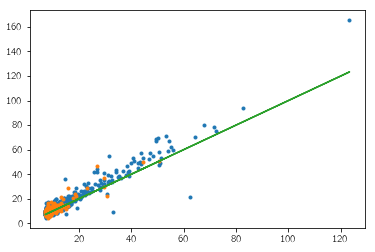

In [388]:
plt.plot(joined.Measured_MES, joined.Expected_MES, ".");
plt.plot(joined.Measured_MES, joined.mes_model, ".")
plt.plot(joined.Measured_MES, joined.Measured_MES);

In [213]:
np.array(star[cdpp_cols], dtype=float)

array([351.664, 312.897, 292.799, 272.105, 259.173, 237.3  , 229.1  ,
       216.051, 203.032, 193.171, 187.575, 182.748, 181.504, 179.365])

In [214]:
np.interp(duration, cdpp_vals, np.array(star[cdpp_cols], dtype=float))

200.43974032

In [154]:
c2 = joined.limbdark_coeff1
c4 = joined.limbdark_coeff4
ror = np.array(joined.i_ror)
b = np.array(joined.i_b)
duration = np.array(joined.i_dur)
depth = (1 - quad.quad(c2, c4, ror, b)) * 1e6
depth

array([ 650.04029133, 1415.08240126,  243.6833939 , ..., 1276.48917412,
        188.52152867, 2459.76573182])

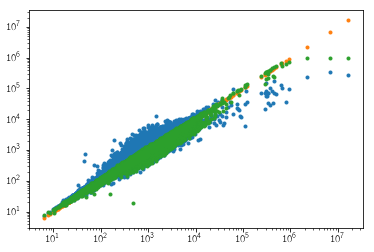

In [164]:
plt.loglog(1e6*joined.i_ror**2, joined.i_depth, ".")
plt.plot(1e6*joined.i_ror**2, 1e6*joined.i_ror**2, ".")
plt.plot(1e6*joined.i_ror**2, depth, ".")

In [156]:
noise = np.empty_like(depth)
for i, (tau, row) in enumerate(zip(duration, np.array(joined[cdpp_cols]))):
    noise[i] = np.interp(tau, cdpp_vals, row)

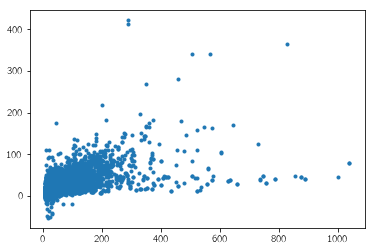

In [134]:
plt.plot(joined.Measured_MES, depth / noise, ".")

In [81]:
X = np.array(df[["i_ror", "i_period", "i_b"]])
m = X[:, 2] > 0.0
X[~m, 2] = 0.5 * X[m, 2].min()
X = np.log(X)
mu = np.mean(X, axis=0)
X -= mu
y = np.log(np.array(df.Measured_MES))

In [93]:
order = 2
As = [np.concatenate((np.ones((len(X), 1)), X), axis=1)]
for order in range(2, 3):
    As.append(np.product(list(
        combinations_with_replacement(X.T, order)), axis=1).T)
A = np.concatenate(As, axis=1)
X.shape, A.shape

((76872, 3), (76872, 10))

In [96]:
np.random.seed(42)
train = np.random.rand(len(X)) < 0.8
w = np.linalg.solve(np.dot(A[train].T, A[train]), np.dot(A[train].T, y[train]))
y_train = np.dot(A[train], w)
y_test = np.dot(A[~train], w)

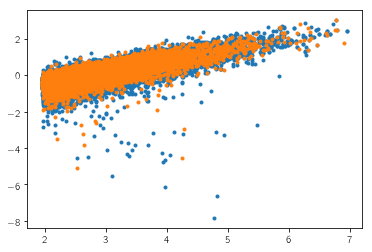

In [98]:
plt.plot(y[train], y[train] - y_train, ".")
plt.plot(y[~train], y[~train] - y_test, ".")

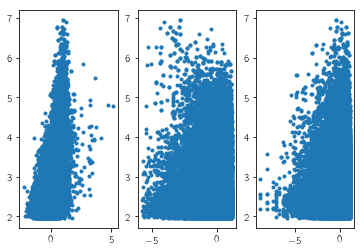

In [83]:
fig, axes = plt.subplots(1, 3)
axes[0].plot(X[:, 0], y, ".");
axes[1].plot(X[:, 1], y, ".");
axes[2].plot(X[:, 2], y, ".");

In [ ]:
pipe = 